In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score ,f1_score,roc_curve
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2
from data_prep import df_prep  
from data_prep import  NLP_Vectorizer
from model_src import NLP_model


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading 

In [3]:
col_names = ['marketplace','customer_id','review_id','product_id','product_parent','product_title','product_category','star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date']
cols = {}
for i in range(len(col_names)):
    print (str(i)+': '+col_names[i])
    cols[col_names[i]] = i

0: marketplace
1: customer_id
2: review_id
3: product_id
4: product_parent
5: product_title
6: product_category
7: star_rating
8: helpful_votes
9: total_votes
10: vine
11: verified_purchase
12: review_headline
13: review_body
14: review_date


In [4]:
np.random.seed(500)
df = pd.read_csv('data/sample_02.csv')
#df = df[df['7']==1]
df = df[df['9']>10]

df = df.sample(frac=.5, random_state=1)
len(df)

9616

In [5]:
Corpus = df_prep(df,.4,.0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [6]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus[['text_final','help_score','help_votes','stars']],Corpus['label'],test_size=0.3)



Train_X_Vector, Test_X_Vector, Train_Y, Test_Y = vectorize_df(Train_X['text_final'], Test_X['text_final'], Train_Y, Test_Y,'TF_IDF')





In [7]:
TF_IDF = NLP_Vectorizer('TF_IDF',{'max_features':2000,'ngram_range':(1,3)})
orig_Test_Y = Test_Y
orig_Train_Y = Train_Y
Test_Y = TF_IDF.encode_Y(Test_Y)
Train_Y = TF_IDF.encode_Y(Train_Y)

In [8]:
TF_IDF.fit(Train_X['text_final'])
Train_X_Vector = TF_IDF.transform(Train_X['text_final'])
Test_X_Vector = TF_IDF.transform(Test_X['text_final'])

In [9]:
NVB = NLP_model('RF',{'n_estimators':500})

In [10]:
NVB.fit(Train_X_Vector,Train_Y)

In [11]:
NVB_predict = NVB.predict(Test_X_Vector)

In [12]:
accuracy_score(NVB_predict,Test_Y)

0.8802228412256268

In [13]:
NVB_predict

array([1, 1, 1, ..., 1, 1, 1])

In [14]:
sum(NVB_predict)/len(NVB_predict)

0.9846796657381616

In [15]:
sum(Test_Y)/len(Test_Y)

0.8774373259052924

In [16]:
Test_X['preds'] = NVB_predict
Test_X['actual'] = Test_Y

In [17]:
Test_X['correct'] = Test_X['preds'] == Test_X['actual']

In [18]:
Test_X['actual']

5210     1
52023    0
43211    1
39514    1
28982    0
        ..
22064    1
56314    1
21649    1
57588    0
41715    0
Name: actual, Length: 2872, dtype: int64

(array([1.200e+01, 9.000e+00, 1.000e+00, 4.000e+00, 1.170e+02, 1.790e+02,
        1.910e+02, 2.750e+02, 4.940e+02, 1.246e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

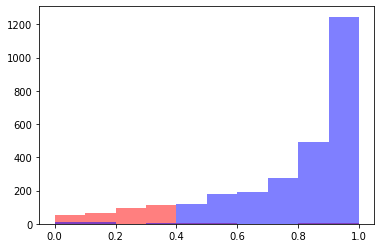

In [20]:
plt.hist(Test_X[Test_X['correct']==False]['help_score'],bins=10,normed=True,color='red',alpha=.5)
plt.hist(Test_X[Test_X['correct']==True]['help_score'],bins=10,normed=True,color='blue',alpha=.5)